In [5]:
cd csv/5000hz/300rpm

[Errno 2] No such file or directory: 'csv/5000hz/300rpm'
/Users/kimdozz0/Documents/GitHub/Capstone_Design/csv/5000hz/300rpm


/var/folders/bh/p7fpj32j1ks5t045jrxnzp780000gn/T/ipykernel_69090/45286381.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = scalers[column].fit_transform(df[[column]])
/var/folders/bh/p7fpj32j1ks5t045jrxnzp780000gn/T/ipykernel_69090/45286381.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = scalers[column].fit_transform(df[[column]])
/var/folders/bh/p7fpj32j1ks5t045jrxnzp780000gn/T/ipykernel_69090/45286381.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy 

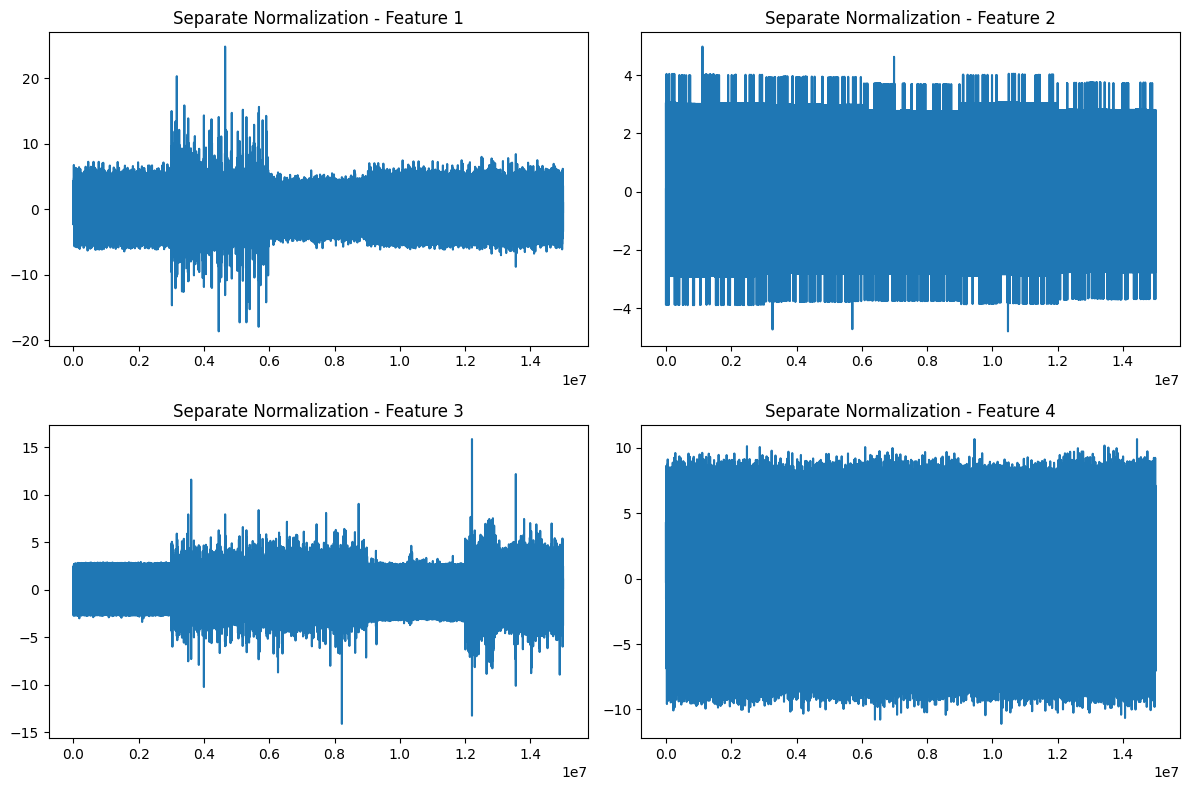

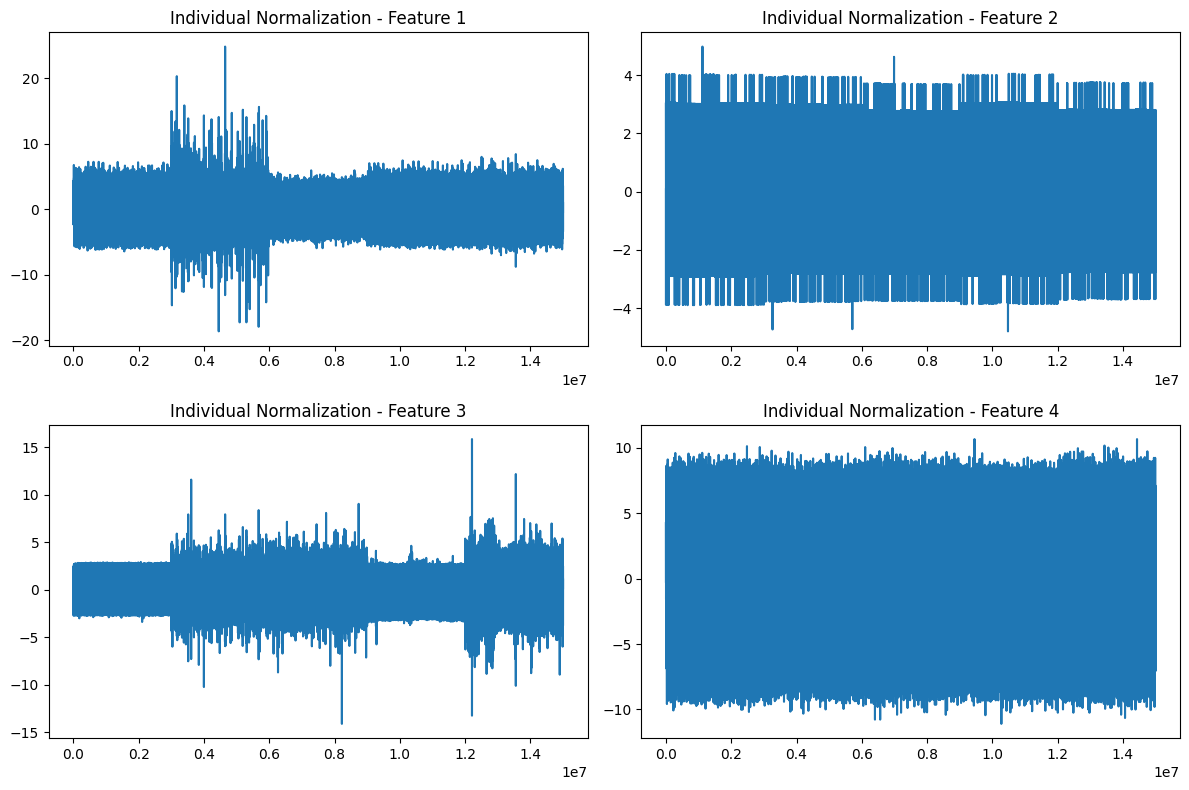

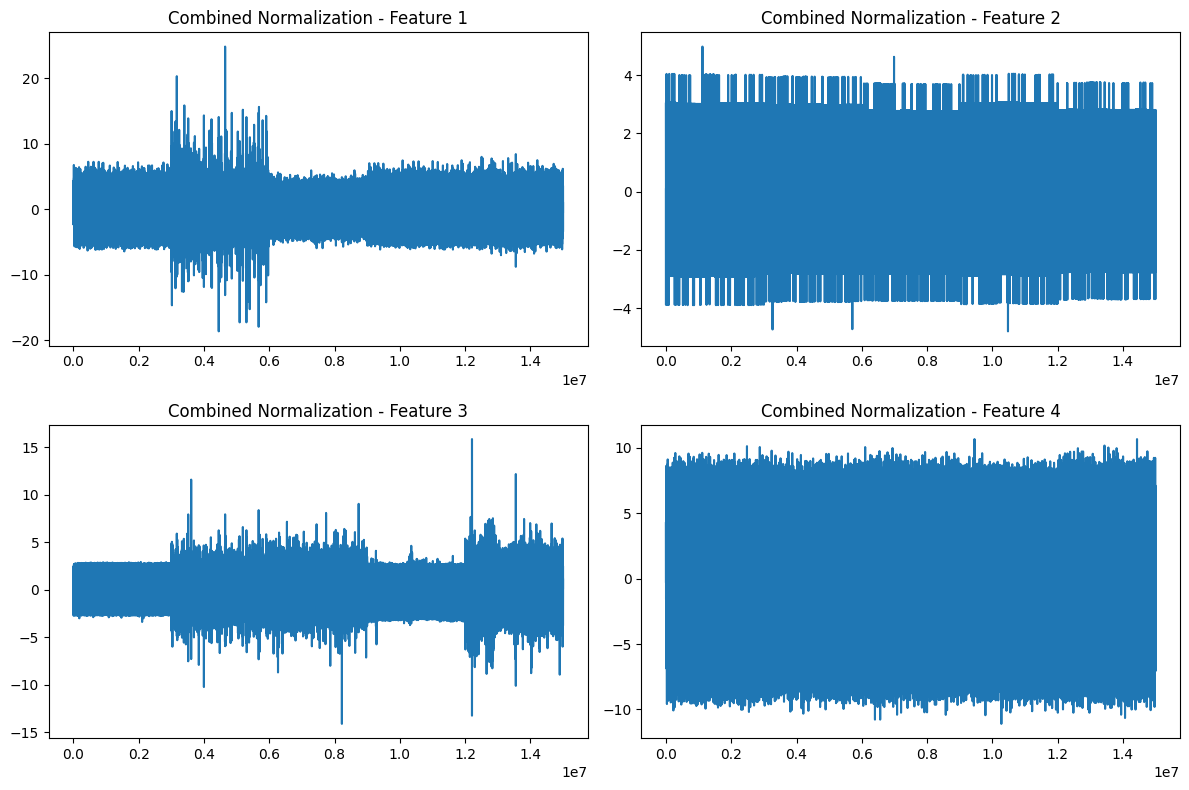

Number of differences between Separate and Individual: 0
Number of differences between Separate and Combined: 0
Number of differences between Individual and Combined: 0


In [6]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 데이터 파일 경로 설정
data_paths = {
    "normal": "300rpm normal data",
    "fault1": "300rpm carriage damage",
    "fault2": "300rpm high-speed damage",
    "fault3": "300rpm lack of lubrication",
    "fault4": "300rpm oxidation and corrosion"
}

# 각 전처리 방법 정의
def normalize_separate(df):
    df = df[['motor1_x', 'motor1_y', 'motor1_z', 'sound']]
    scaler_motor = StandardScaler()
    scaler_sound = StandardScaler()
    motor_data = scaler_motor.fit_transform(df[['motor1_x', 'motor1_y', 'motor1_z']])
    sound_data = scaler_sound.fit_transform(df[['sound']])
    return np.hstack([motor_data, sound_data])

def normalize_individual(df):
    df = df[['motor1_x', 'motor1_y', 'motor1_z', 'sound']]
    scalers = {}
    for column in df.columns:
        scalers[column] = StandardScaler()
        df[column] = scalers[column].fit_transform(df[[column]])
    return df.values

def normalize_combined(df):
    df = df[['motor1_x', 'motor1_y', 'motor1_z', 'sound']]
    scaler = StandardScaler()
    return scaler.fit_transform(df)

# 데이터 로드 및 정규화 함수
def load_and_normalize_data(path, normalize_func):
    data_list = []
    for filename in os.listdir(path):
        if filename.endswith(".csv"):
            df = pd.read_csv(os.path.join(path, filename))
            combined_data = normalize_func(df)
            data_list.append(combined_data)
    return np.vstack(data_list)

# 파일별 데이터 로드 및 정규화
data_separate = []
data_individual = []
data_combined = []

for key, path in data_paths.items():
    data_separate.append(load_and_normalize_data(path, normalize_separate))
    data_individual.append(load_and_normalize_data(path, normalize_individual))
    data_combined.append(load_and_normalize_data(path, normalize_combined))

data_separate = np.vstack(data_separate)
data_individual = np.vstack(data_individual)
data_combined = np.vstack(data_combined)

# 시각화 함수
def plot_normalized_data(data, title):
    plt.figure(figsize=(12, 8))
    for i in range(data.shape[1]):
        plt.subplot(2, 2, i + 1)
        plt.plot(data[:, i])
        plt.title(f'{title} - Feature {i + 1}')
    plt.tight_layout()
    plt.show()

# 시각화
plot_normalized_data(data_separate, 'Separate Normalization')
plot_normalized_data(data_individual, 'Individual Normalization')
plot_normalized_data(data_combined, 'Combined Normalization')

# 데이터 비교 함수
def compare_normalized_data(data1, data2, name1, name2):
    comparison = np.isclose(data1, data2)
    differences = np.where(~comparison)
    num_differences = len(differences[0])
    print(f"Number of differences between {name1} and {name2}: {num_differences}")
    if num_differences > 0:
        print(f"Indices of differences: {differences}")

# 데이터 비교
compare_normalized_data(data_separate, data_individual, 'Separate', 'Individual')
compare_normalized_data(data_separate, data_combined, 'Separate', 'Combined')
compare_normalized_data(data_individual, data_combined, 'Individual', 'Combined')

In [7]:
#4개 데이터를 각각 따로 정규화
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, accuracy_score
from scipy.signal import stft

# 데이터 파일 로드 및 정규화
def normalize_data(df, column):
    scaler = StandardScaler()
    return scaler.fit_transform(df[[column]])

def load_and_normalize_data(filenames, label):
    data_list = []
    for filename in filenames:
        df = pd.read_csv(filename)
        motor_x_normalized = normalize_data(df, 'motor1_x')
        motor_y_normalized = normalize_data(df, 'motor1_y')
        motor_z_normalized = normalize_data(df, 'motor1_z')
        sound_normalized = normalize_data(df, 'sound')
        combined_data = np.hstack([motor_x_normalized, motor_y_normalized, motor_z_normalized, sound_normalized])
        data_list.append((combined_data, label))
    return data_list

# 파일 리스트
normal_files = ["300rpm normal data/stream2024_4_22_23_22.csv"]
fault1_files = ["300rpm carriage damage/stream2024_4_23_2_56.csv"]
fault2_files = ["300rpm high-speed damage/stream2024_4_23_0_20.csv"]
fault3_files = ["300rpm lack of lubrication/stream2024_4_23_2_6.csv"]
fault4_files = ["300rpm oxidation and corrosion/stream2024_4_23_1_15.csv"]

# 데이터 로드 및 정규화
data_normal = load_and_normalize_data(normal_files, 0)
data_fault1 = load_and_normalize_data(fault1_files, 1)
data_fault2 = load_and_normalize_data(fault2_files, 2)
data_fault3 = load_and_normalize_data(fault3_files, 3)
data_fault4 = load_and_normalize_data(fault4_files, 4)

all_data = data_normal + data_fault1 + data_fault2 + data_fault3 + data_fault4

# 시계열 데이터를 윈도우로 분할
def create_windows(data, window_size, stride):
    windows = []
    labels = []
    for (combined_data, label) in data:
        num_windows = (len(combined_data) - window_size) // stride + 1
        for i in range(num_windows):
            window = combined_data[i*stride:i*stride + window_size, :]
            windows.append(window)
            labels.append(label)
    return np.array(windows), np.array(labels)

window_size = 100
stride = 50
features, labels = create_windows(all_data, window_size, stride)

print(f'Number of windows created: {features.shape[0]}')

# STFT 변환 함수
def apply_stft(windows, nperseg=50):
    stft_windows = []
    for window in windows:
        stft_result = []
        for signal in window.T:
            f, t, Zxx = stft(signal, nperseg=min(len(signal), nperseg))
            stft_result.append(np.abs(Zxx))
        stft_windows.append(np.array(stft_result))
    return np.array(stft_windows)

# STFT 변환 적용
stft_features = apply_stft(features)

# STFT 결과를 (samples, time, features) 형태로 변환
stft_features = stft_features.transpose(0, 2, 1, 3)  # (samples, time, features)

# 노드 특성 정규화
scaler = StandardScaler()
features_scaled = scaler.fit_transform(stft_features.reshape(stft_features.shape[0], -1))

# 데이터를 학습 및 평가용으로 분할
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.2, random_state=42)

# 데이터를 3D 형태로 변환 (batch_size, sequence_length, input_size)
X_train = X_train.reshape(X_train.shape[0], -1, stft_features.shape[3])
X_test = X_test.reshape(X_test.shape[0], -1, stft_features.shape[3])

# 데이터셋 및 데이터로더 생성
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# CNN BiLSTM Autoencoder 모델 정의
class CNNBiLSTMAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(CNNBiLSTMAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.lstm = nn.LSTM(32, hidden_size, batch_first=True, bidirectional=True)
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=128, out_channels=input_size, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # BiLSTM이므로 hidden_size * 2

    def forward(self, x):
        x = x.transpose(1, 2)  # (batch_size, input_size, seq_length)
        x = self.encoder(x)  # (batch_size, 128, seq_length//8)
        x = x.transpose(1, 2)  # (batch_size, seq_length//8, 128)
        h0 = torch.zeros(2, x.size(0), hidden_size).to(x.device)  # 초기 hidden state, bidirectional이므로 2
        c0 = torch.zeros(2, x.size(0), hidden_size).to(x.device)  # 초기 cell state, bidirectional이므로 2
        _, (hn, _) = self.lstm(x, (h0, c0))  # (2, batch_size, hidden_size)
        hn = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim = 1)  # 두 방향의 출력을 합침
        x = self.decoder(x.transpose(1, 2))  # (batch_size, input_size, seq_length)
        x = x.transpose(1, 2)  # (batch_size, seq_length, input_size)
        out = self.fc(hn)  # (batch_size, num_classes)
        return x, out

# 하이퍼파라미터 설정
input_size = stft_features.shape[3]  # STFT 변환 후의 각 시퀀스의 특징 차원
hidden_size = 64
num_classes = len(np.unique(labels))  # 고장 유형 수

# 모델 초기화
model = CNNBiLSTMAutoencoder(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 모델 학습
num_epochs = 100
model.train()
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        inputs = inputs.view(-1, inputs.shape[1], input_size)  # 입력 형태 (batch_size, seq_length, input_size)
        _, outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

# 모델 평가
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.view(-1, inputs.shape[1], input_size)  # 입력 형태 (batch_size, seq_length, input_size)
        _, outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

print("Accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

Number of windows created: 29995


/Users/kimdozz0/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 10/100, Loss: 0.0002
Epoch 20/100, Loss: 0.0000
Epoch 30/100, Loss: 0.0000
Epoch 40/100, Loss: 0.0000
Epoch 50/100, Loss: 0.0000
Epoch 60/100, Loss: 0.0000
Epoch 70/100, Loss: 0.0000
Epoch 80/100, Loss: 0.0001
Epoch 90/100, Loss: 0.0000
Epoch 100/100, Loss: 0.0000
Accuracy: 0.9964994165694282
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1179
           1       0.99      1.00      0.99      1217
           2       0.99      0.99      0.99      1225
           3       1.00      1.00      1.00      1172
           4       1.00      1.00      1.00      1206

    accuracy                           1.00      5999
   macro avg       1.00      1.00      1.00      5999
weighted avg       1.00      1.00      1.00      5999

